In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

In [2]:
import pyleoclim as pyleo

In [3]:
from pyleoclim import tests

## Series

In [4]:
soi_data = tests.load_dataset('soi', skiprows=1)
soi_data['Date'] = pd.to_datetime(soi_data['Date'], format='%Y%m')
nt = len(soi_data)
to = np.linspace(1951, 2020-1/12, nt)
Xo = soi_data['Value'].values

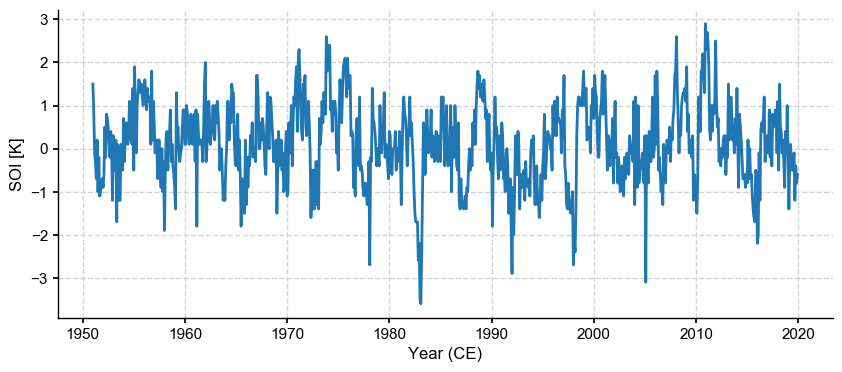

In [26]:
ts = pyleo.Series(time=to, value=Xo, time_name='Year (CE)', value_name='SOI', value_unit='K')
# print(ts)

fig, ax = ts.plot()
# fig, ax = ts.plot(marker='o', color='r', legend=True, label='SOI')
# fig, ax = ts.plot(linewidth=1, label='SOI', legend=False)
# fig, ax = ts.plot(lgd_kwargs={'frameon': True}, linestyle='--', label='SOI')

In [75]:
# precalculate the scalogram and PSD with significance test
scal = ts.wavelet().signif_test(number=1)
psd = ts.spectral().signif_test(number=1)

Performing spectral analysis on surrogates: 100%|██████████| 1/1 [00:10<00:00, 10.31s/it]


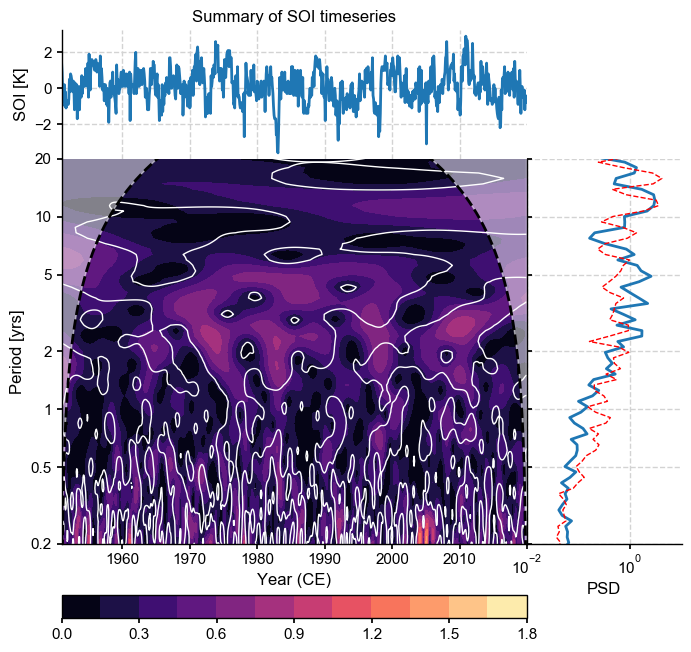

In [90]:
# summary plot
fig, ax = ts.summary_plot(
    scalogram=scal, psd=psd,
#     time_lim=[1950, 2020], value_lim=[-3, 3],
    psd_lim=[1e-2, 1e1],
#     period_lim=[0.2, 50],
    value_label='SOI [K]',
    period_label='Period [yrs]',
    time_label='Year (CE)',
    psd_label='PSD',
    title='Summary of SOI timeseries'
)
pyleo.showfig(fig)

In [7]:
fig, ax = ts.plot(savefig_settings={'path': './figs/soi.pdf'})

Figure saved at: "figs/soi.pdf"


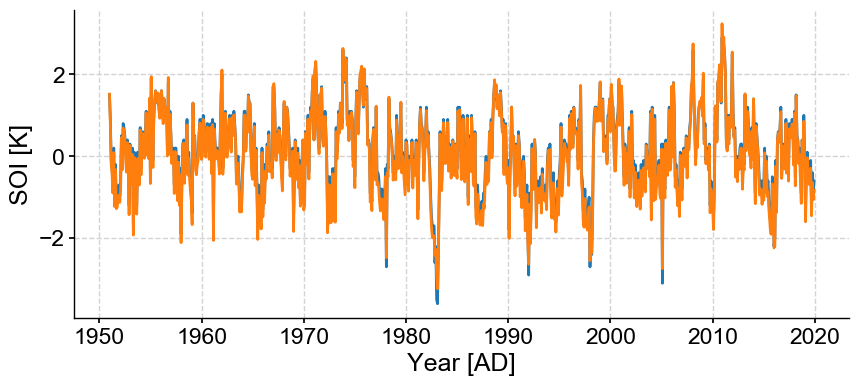

In [8]:
fig, ax = ts.plot(mute=True)

ax = ts.gaussianize().plot(ax=ax)

pyleo.showfig(fig)

##  Spectral analysis on the Series

In [9]:
%%time
psd_wwz = ts.spectral()

CPU times: user 1min 10s, sys: 219 ms, total: 1min 11s
Wall time: 13.3 s


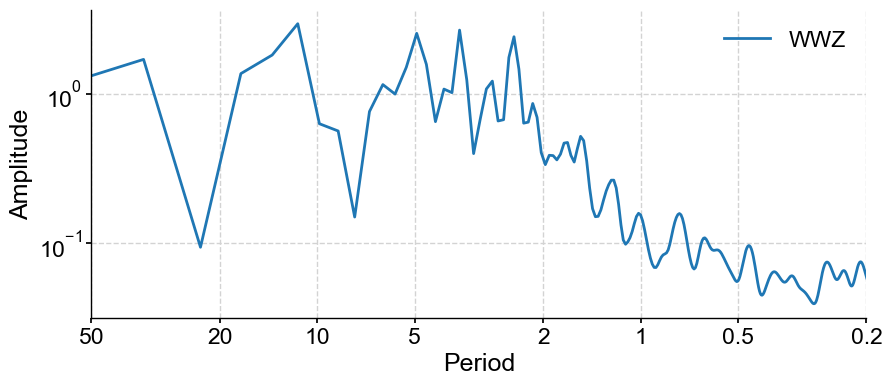

In [10]:
fig, ax = psd_wwz.plot(label='WWZ')

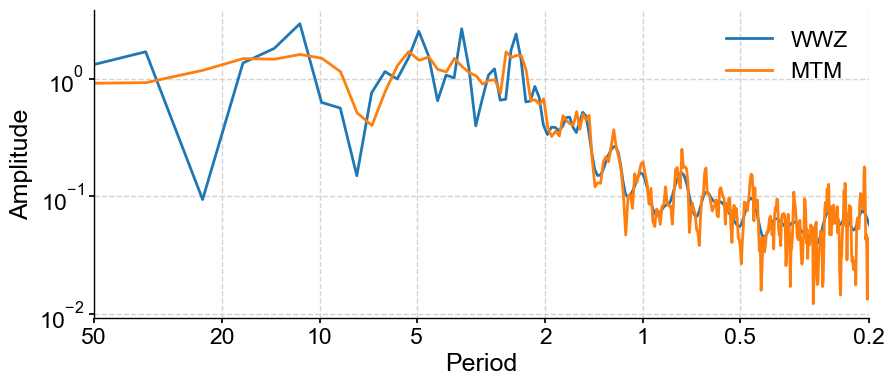

In [11]:
psd_mtm = ts.spectral(method='mtm')
ax = psd_mtm.plot(ax=ax, label='MTM')

pyleo.showfig(fig)

## Wavelet analysis on the Series

In [6]:
%%time
scal = ts.wavelet()

CPU times: user 7.31 s, sys: 373 ms, total: 7.68 s
Wall time: 5.51 s


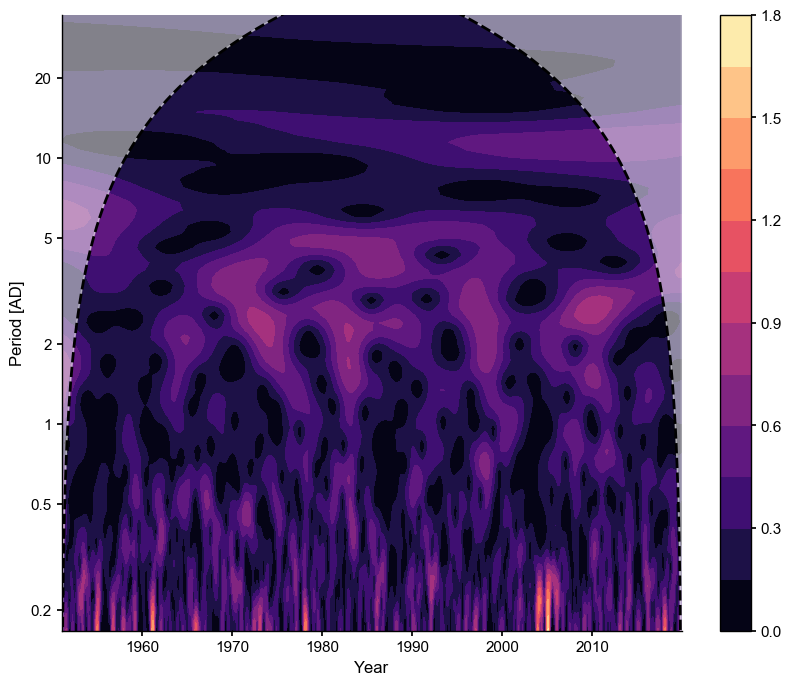

In [7]:
fig, ax = scal.plot()

## Wavelet coherence analysis on two Series objs

In [4]:
import scipy.io as sio
import matplotlib.pyplot as plt

data = sio.loadmat('../example_data/wtc_test_data_nino.mat')
air = data['air'][:, 0]
nino = data['nino'][:, 0]
t = data['datayear'][:, 0]

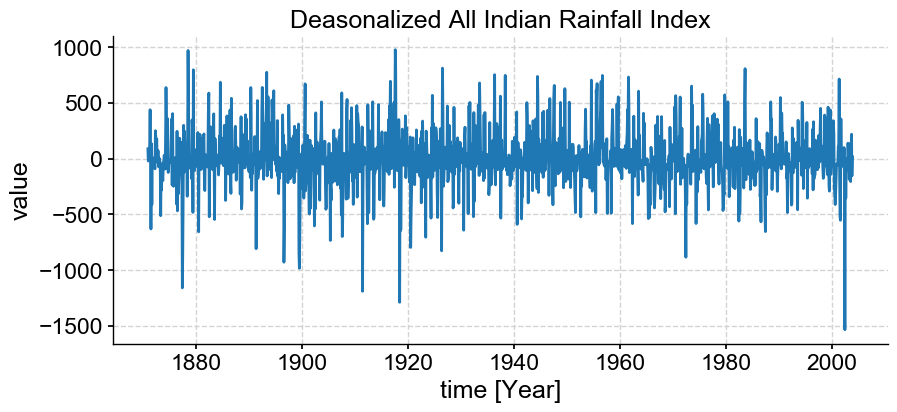

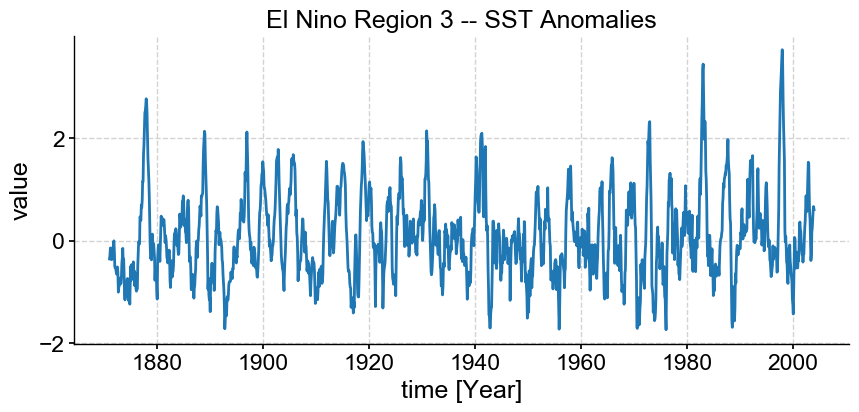

In [17]:
ts_air = pyleo.Series(time=t, value=air, time_unit='Year')
ts_nino = pyleo.Series(time=t, value=nino, time_unit='Year')

fig, ax = ts_air.plot(title='Deasonalized All Indian Rainfall Index')
fig, ax = ts_nino.plot(title='El Nino Region 3 -- SST Anomalies')

In [20]:
coh = ts_air.wavelet_coherence(ts_nino)

/home/fzhu/Apps/Pyleoclim_util/pyleoclim/utils/wavelet.py:1775: UserWarning: The boundaries of tau are not exactly on two of the time axis points,and it will be adjusted to be so.
  tau_lb = np.min(ts[ts > np.min(tau)])


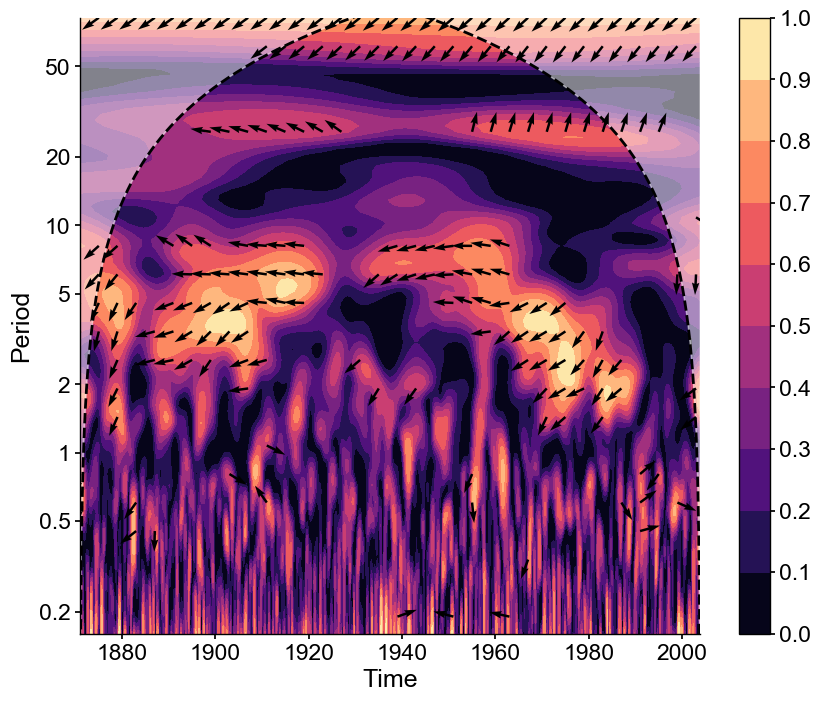

In [21]:
fig, ax = coh.plot(phase_style={'skip_x': 50})

In [39]:
%%time
coh = coh.signif_test(number=10)

Performing wavelet coherence on surrogate pairs: 100%|██████████| 10/10 [01:26<00:00,  8.65s/it]


CPU times: user 2min 54s, sys: 566 ms, total: 2min 55s
Wall time: 1min 32s


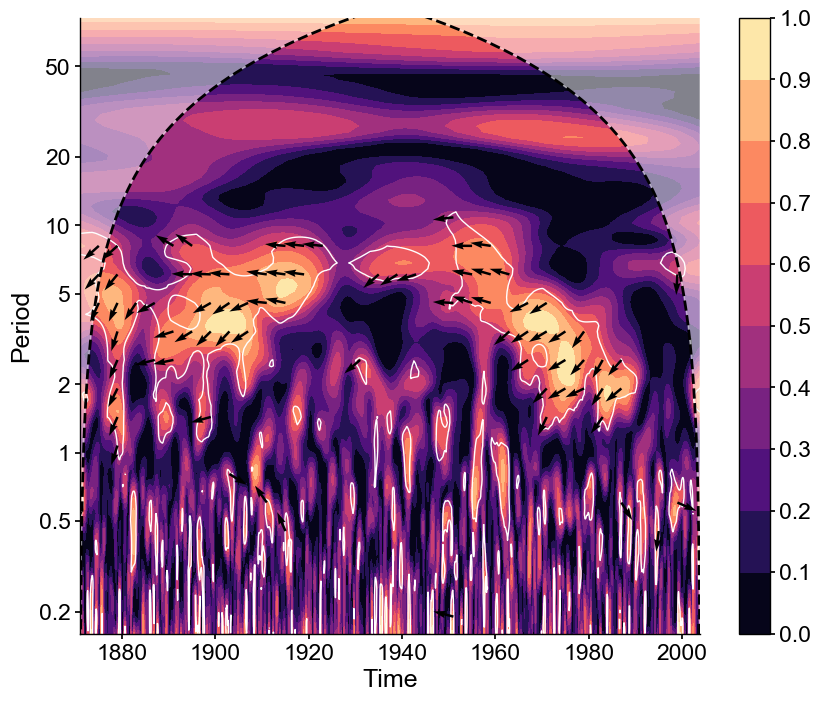

In [42]:
fig, ax = coh.plot(phase_style={'skip_x': 50})

##  Correlation analysis

In [18]:
corr_res = ts_air.correlation(ts_nino)
print(corr_res)

{'r': -0.15239413332839044, 'signif': True, 'pvalue': 0.0}


## Causality analysis

In [19]:
causal_res = ts_air.causality(ts_nino)
print(causal_res)

Calculating causality between surrogates: 100%|██████████| 1000/1000 [00:00<00:00, 1781.13it/s]

{'T21': 0.01644548028633629, 'tau21': 0.011968992003857067, 'Z': 1.3740071244960856, 'signif_qs': [0.005, 0.025, 0.05, 0.95, 0.975, 0.995], 'T21_noise': array([-9.96111870e-05, -4.11123636e-05, -1.78172023e-05,  2.92317426e-03,
        3.87387400e-03,  5.81602184e-03]), 'tau21_noise': array([-7.39768352e-05, -3.05415464e-05, -1.32332904e-05,  2.16150894e-03,
        2.86350097e-03,  4.28776998e-03])}


## Surrogates

In [20]:
surr = ts_nino.surrogates(number=100, seed=2333)

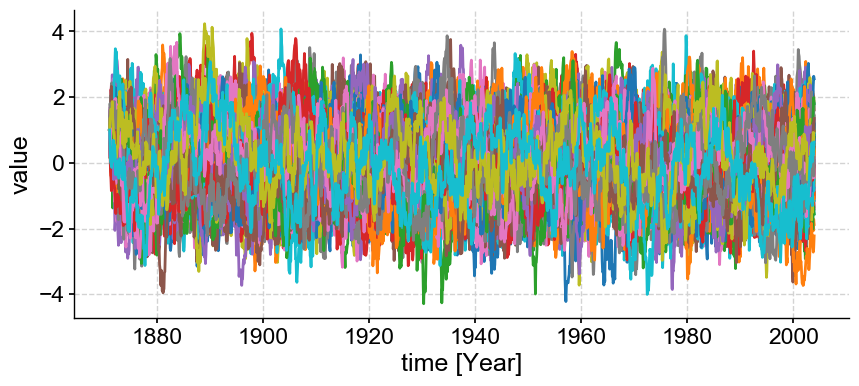

In [21]:
fig, ax = surr.plot()

In [28]:
surr_psd = surr.spectral(method='mtm')

Performing spectral analysis on surrogates: 100%|██████████| 100/100 [00:04<00:00, 24.99it/s]


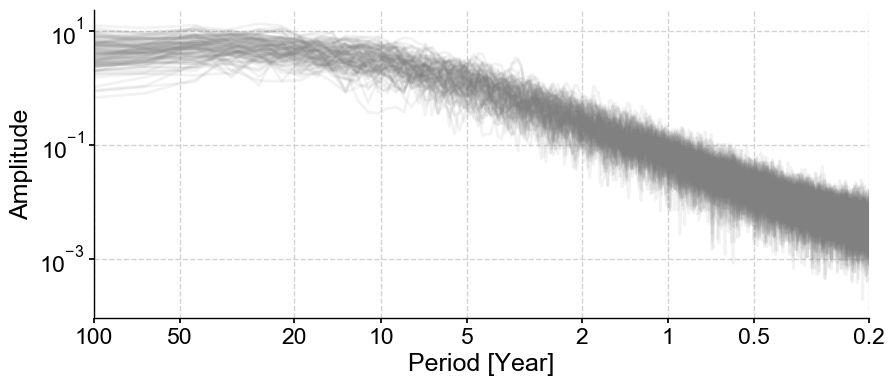

In [29]:
fig, ax = surr_psd.plot(plot_kwargs={'color': 'gray', 'alpha': 0.1})

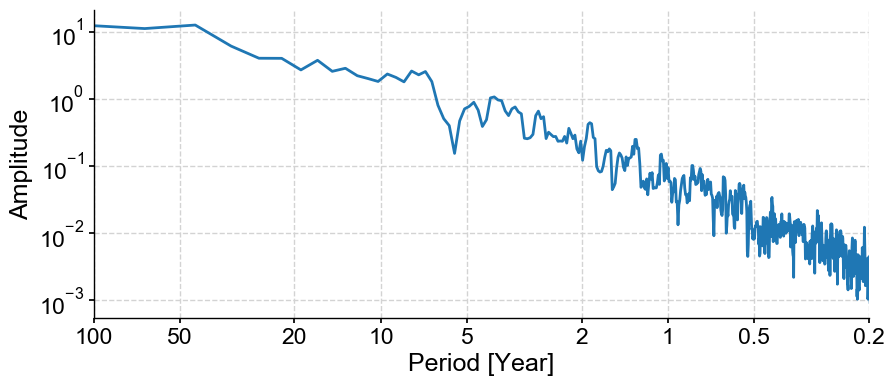

(<Figure size 1000x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fed9928a610>)

In [30]:
surr_psd.psd_list[0].plot()

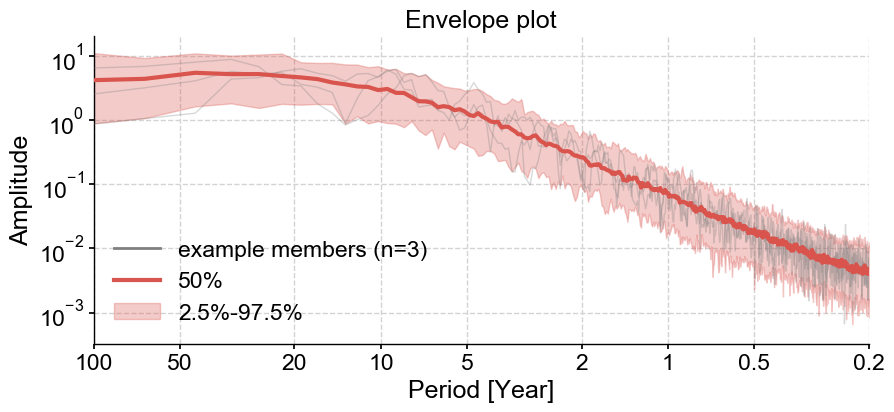

In [36]:
fig, ax = surr_psd.plot_envelope(title='Envelope plot', members_plot_num=3)

In [39]:
surr_qs = surr_psd.quantiles()

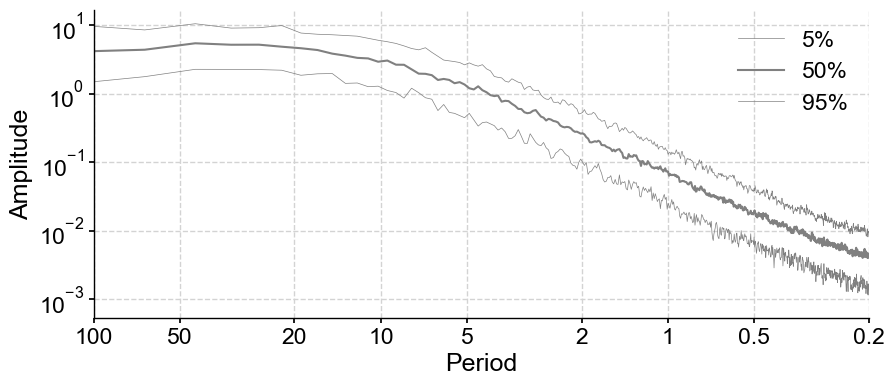

In [40]:
fig, ax = surr_qs.plot()

## Significance test with AR(1) for spectral analysis

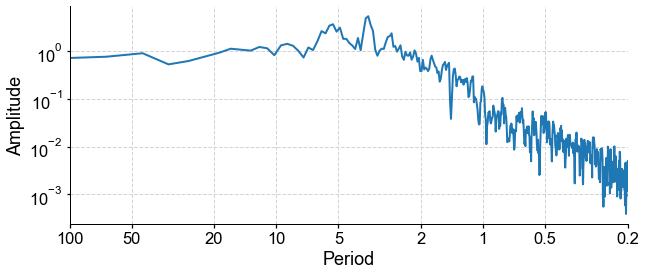

In [26]:
psd = ts_nino.spectral(method='mtm')
fig, ax = psd.plot()

In [30]:
psd = psd.signif_test()

100%|██████████| 200/200 [00:08<00:00, 22.28it/s]


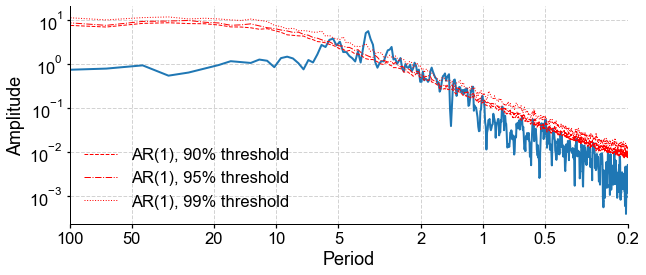

In [31]:
fig, ax = psd.plot()

100%|██████████| 200/200 [00:07<00:00, 25.46it/s]


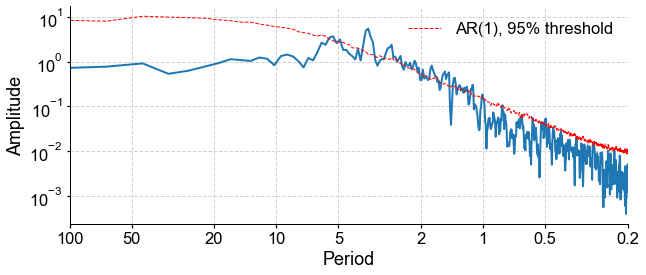

In [29]:
fig, ax = ts_nino.spectral(method='mtm').signif_test(qs=[0.95]).plot()

## Significance test in wavelet analysis

In [26]:
surr = ts.surrogates(number=1)
surr_scal = surr.wavelet()

Performing wavelet analysis on surrogates: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


In [27]:
surr_qs = surr_scal.quantiles()

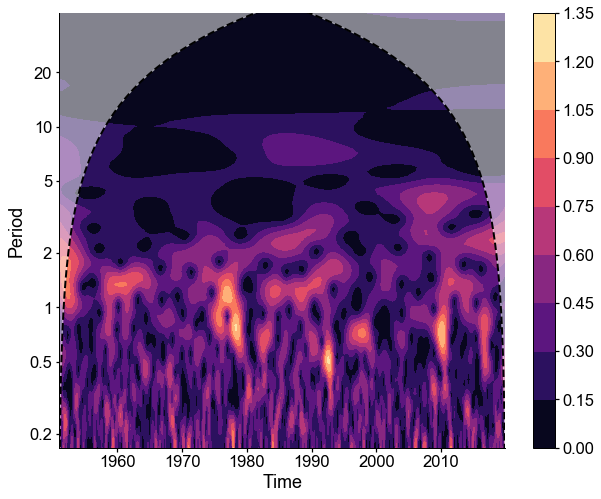

In [28]:
fig, ax = surr_qs.scalogram_list[-1].plot()

In [29]:
%%time
scal = ts.wavelet()

CPU times: user 4.48 s, sys: 22.7 ms, total: 4.5 s
Wall time: 3.51 s


In [30]:
scal = scal.signif_test(qs=[0.95], number=1)

Performing wavelet analysis on surrogates: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


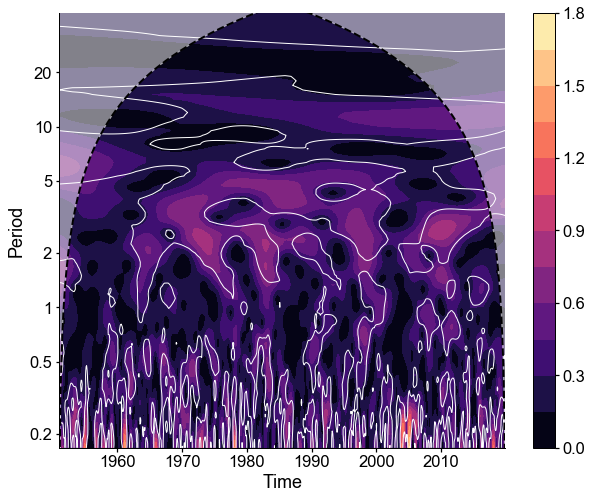

In [8]:
fig, ax = scal.plot()

Performing wavelet analysis on surrogates: 100%|██████████| 10/10 [00:36<00:00,  3.65s/it]


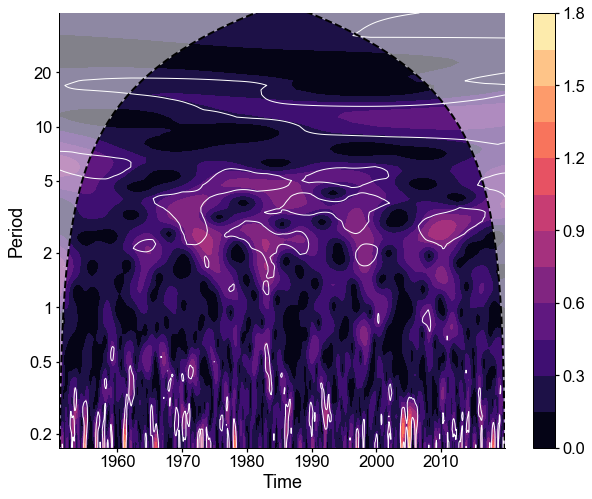

In [10]:
# one-line workflow
fig, ax = ts.wavelet().signif_test(number=10).plot()